In [ ]:
# Import librairies
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers

<ipython-input-1-822850982b33>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# load the data
df = pd.read_csv('/content/sunspot_data.csv', delimiter=',', na_values=['-1'])
df.dataframeName = 'sunspot_data.csv'
del(df['Unnamed: 0'])
df.columns = ['year', 'month', 'day', 'fraction','sunspots', 'sdt', 'obs','indicator']
df.head(-5)

# Add the column time
df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)
# time column is the index of the dataframe
df.index = df['time']
# replace the Nan by linear interpolation
df['sunspots'].interpolate(method='linear', inplace=True)

<ipython-input-2-dc371997f5a7>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['time']=df[['year', 'month', 'day']].apply(lambda s: pd.datetime(*s),axis = 1)


## Time serie creation
**Data are resample monthly and quarter**

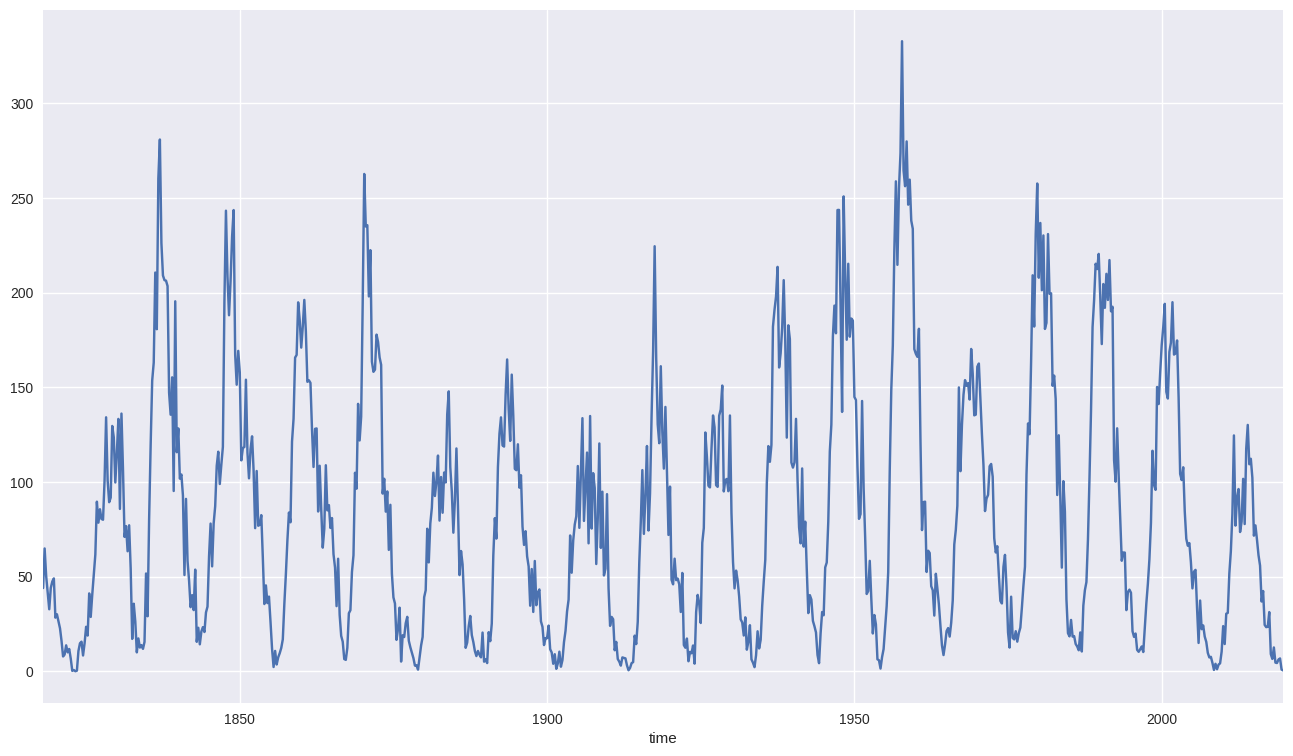

In [ ]:
ts = pd.Series(data=df.sunspots, index=df.index)
#ts = ts['1900-01-01':]
ts_month = ts.resample('MS').mean()
ts_quarter = ts.resample('Q').mean()
ts_quarter.plot()
plt.show()

First plot PACF and ACF

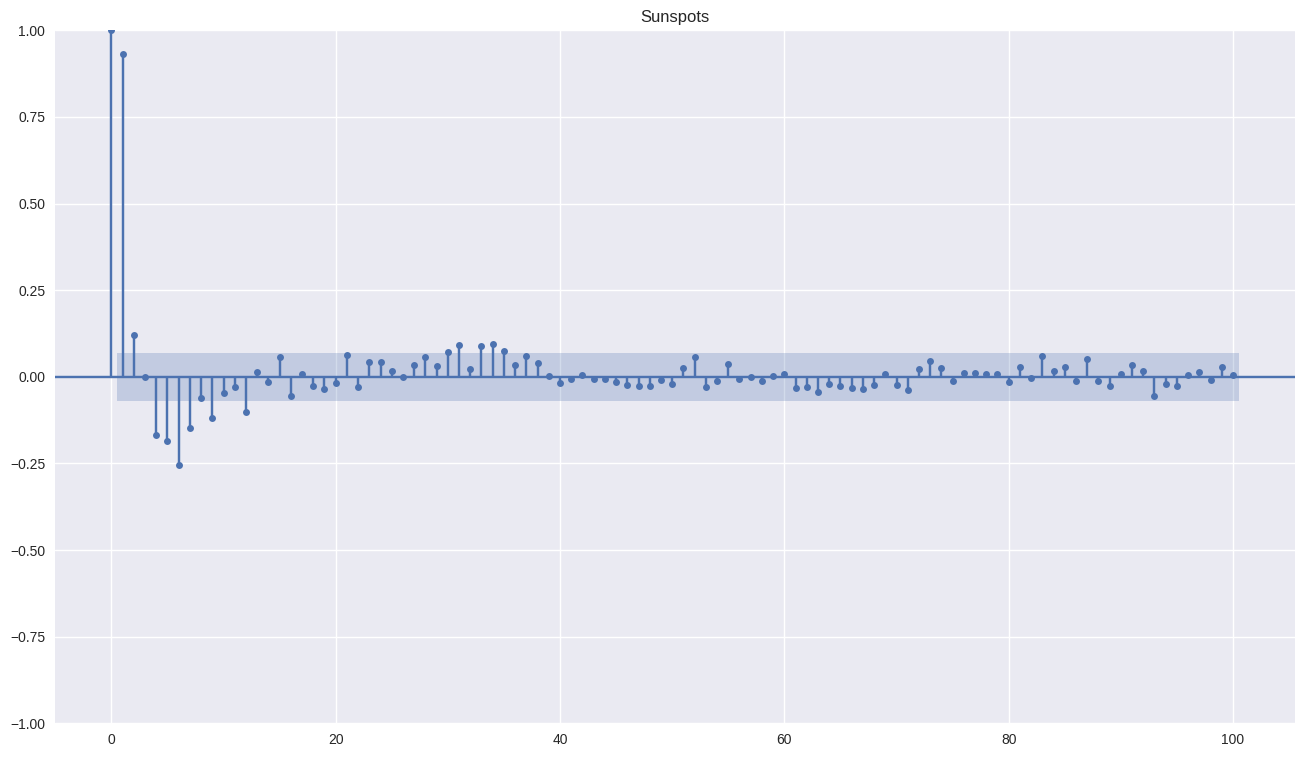

In [ ]:
plot_pacf(ts_quarter,lags=100,title='Sunspots')
plt.show()

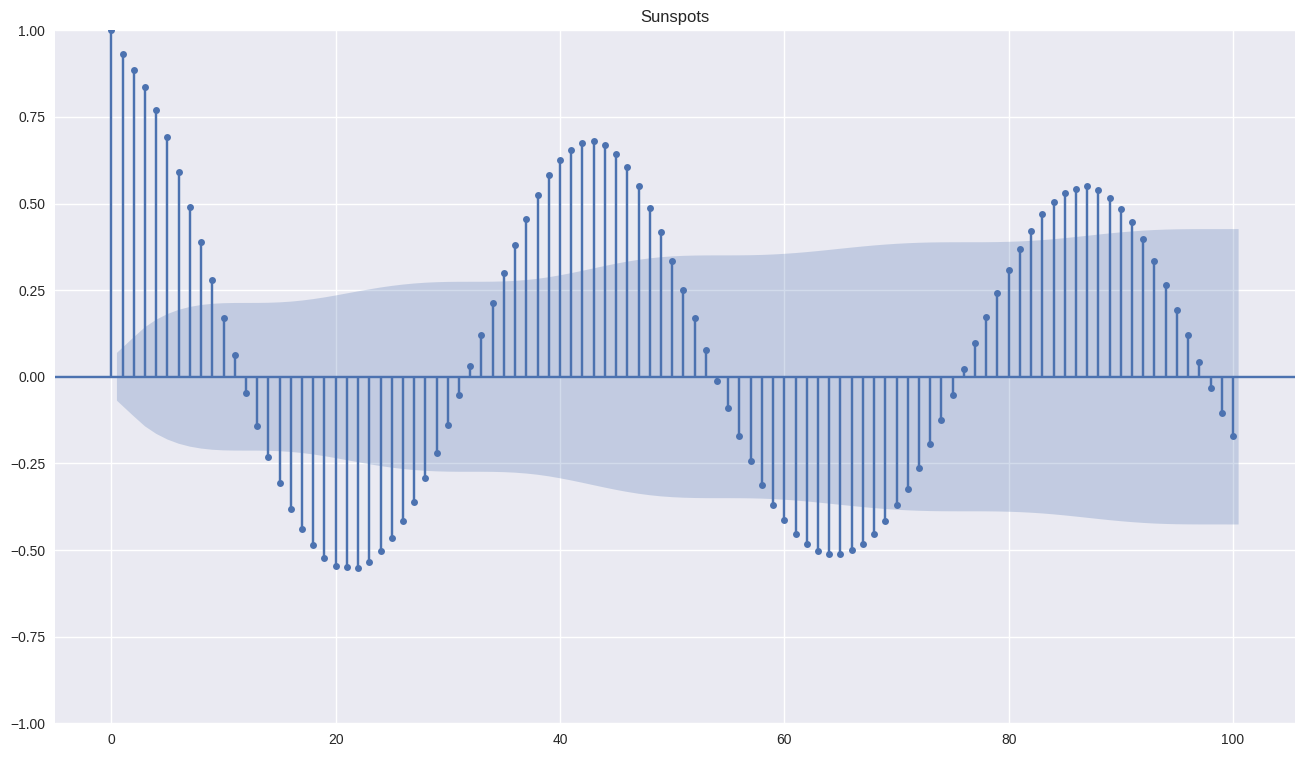

In [ ]:
plot_acf(ts_quarter,lags=100,title='Sunspots')
plt.show()

### Find the order of differencing (d) ?
The test of stationarity is significative with non differencing, so d=0

In [ ]:
from statsmodels.tsa.stattools import adfuller
def printADFTest(serie):
    result = adfuller(serie, autolag='AIC')
    print("ADF Statistic %F" % (result[0]))
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print('\n')

#d = 0
printADFTest(ts_quarter)
#d = 1
#printADFTest(ts_quarter.diff(1).dropna())

ADF Statistic -9.778954
p-value: 6.814515890287507e-17
Critial Values:
   1%, -3.4385918508847646
Critial Values:
   5%, -2.865177791819505
Critial Values:
   10%, -2.568707096601096




In [ ]:
model = sm.tsa.statespace.SARIMAX(ts_quarter, trend='n', order=(3,0,10), seasonal_order=(1,1,0,43))
results = model.fit()
print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                             sunspots   No. Observations:                  808
Model:             SARIMAX(3, 0, 10)x(1, 1, [], 43)   Log Likelihood               -3584.094
Date:                              Sun, 15 Oct 2023   AIC                           7198.189
Time:                                      16:41:12   BIC                           7267.787
Sample:                                  03-31-1818   HQIC                          7224.982
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8982      0.130      6.921      0.000       0.644       1.153
ar.L2          0.76

## Plot the forecast

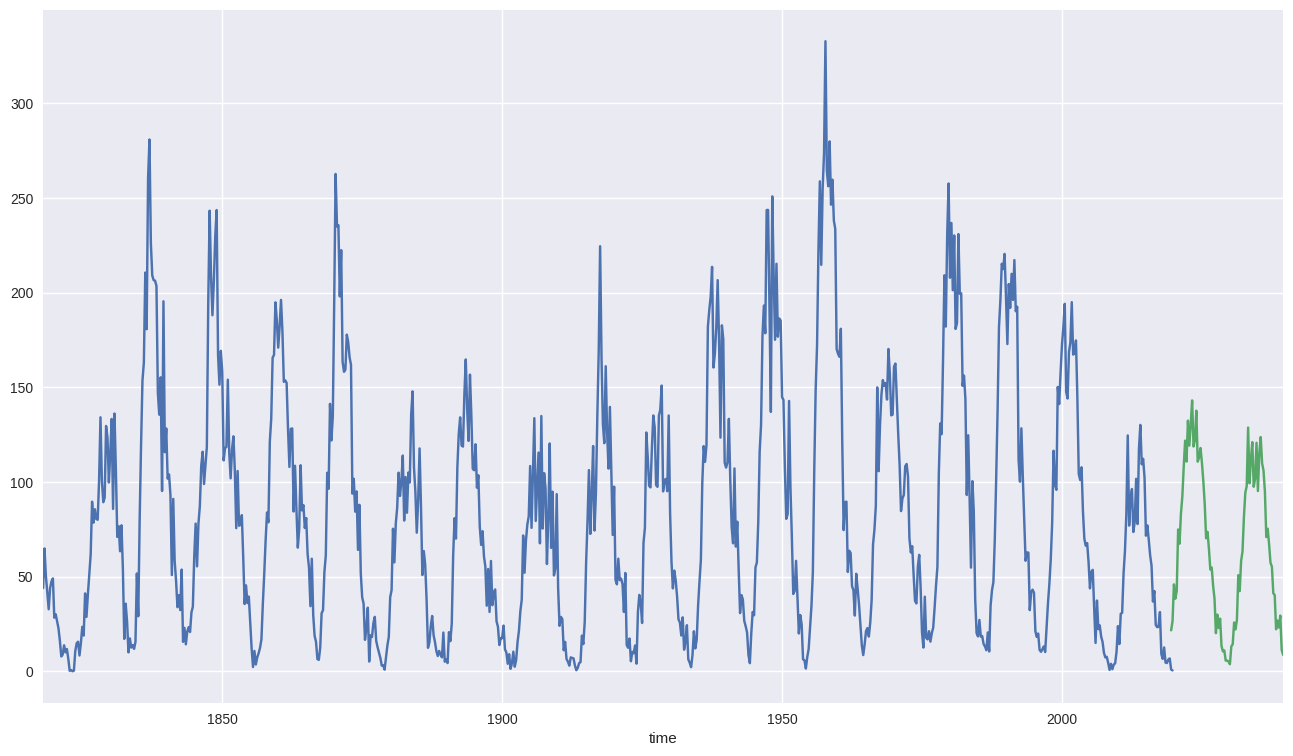

In [ ]:
forecast = results.predict(start = ts_quarter.index[-2], end= ts_quarter.index[-2] + pd.DateOffset(months=240), dynamic= True)
ts_quarter.plot()
forecast.plot()
plt.show()